In [1]:
from ipywidgets.widgets import HBox,VBox, Layout, Output, Button, Label, Text, RadioButtons, IntProgress
from IPython.display import Javascript, display, FileLink, HTML
from ipywidgets import widgets

from metadata.widgets import upload_file_button

import os
import glob as glob


try:
    custom_widgets
    importlib.reload(custom_widgets)
except NameError:
    import custom_widgets

#####################################
######       Appearance        ######
#####################################

title='Hygrometer Plot Dashboard'
 
description='This tool is a dashboard to view hygrometer data throughout MatSci.'
 
# Add more than 1 author to the list using the name-email key-value pair
authors=[{'name':'Kevin DeBoyace', 'email': 'kevin.deboyace@pfizer.com'}]
 
# Add more instructions by adding to the list
instructions=['text1',
              'text2'
             ]

hdr = custom_widgets.header(title=title,
                      description=description,
                      authors=authors,
                      instructions=instructions)



display(hdr) # display header



box_layout = Layout(display = 'flex',
                    flex_flow = 'row',
                    align_items = 'center',
                    #border = '0.5px solid black',
                    width = '40%',
                    justify_content='center'
                   )

#####################################
#####     Import file button    #####
#####################################
box_file, upload_file = upload_file_button()

upload_bx = HBox([upload_file], layout = box_layout)
#display(upload_bx)


# Run button
def run_all(ev): # function to run all jupyter cells below this one
    display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))

def run_next(ev): # function to run specific jupyter cell
    display(Javascript("Jupyter.notebook.execute_cells([2])"))

exec_button = Button(description="Run")
exec_button.style.button_color='MediumSeaGreen'
exec_button.on_click(run_all)




#####################################
#####      Display Buttons      #####
##################################### 
# Display upload button
upload_box = HBox([upload_file], layout = box_layout)
display(upload_box)
# Display execute button
#run_bx = HBox([exec_button], layout = box_layout)
#display(run_bx)
# display delete buttons
#horz_box = HBox([del_csv_button, del_ris_button], layout = box_layout)
horz_box = HBox([exec_button], layout = box_layout)
display(horz_box)


# observe status (upload)
def on_change_uploadfile(c): # currently unused
    print(c.new)
       

HTML(value='<style>\n    #custom-header div {\n        margin-bottom: 10px;\n    }\n    #authors ul {\n       …

In [2]:
#from metadata import hygrometer_plots

In [3]:
#%%
# Hygrometer_plots

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import glob as glob
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#####################################
#####      Import CSV files      #####
##################################### 
def get_csv():
    f1 = glob.glob('*.csv')
    f2 = glob.glob('*.CSV')
    file_names = f1+f2
    return file_names


file_names = get_csv() # Get csv files


#####################################
#####         Plotting          #####
#####################################
cmap = plt.cm.get_cmap('tab10') # get colormap

# plot hygrometer data 
def plot_hygrom(df):
    # Internal channel
    fig, ax1 = plt.subplots()
    ax1.plot(df.datetime, df.temp1, color=cmap(0), linewidth=0.7)
    ax1.set_xlabel('Date')
    plt.xticks(rotation=45, ha='right')
    ax1.set_ylabel('Int Temperature (C)', color=cmap(0))
    
    ax2=ax1.twinx()
    ax2.plot(df.datetime, df.rh1, color=cmap(1), linewidth=0.7)
    ax2.set_ylabel('Int Relative Humidity (%)', color=cmap(1))
    plt.xticks(rotation=45, ha='right')
    
    # External channel
    fig, ax3 = plt.subplots()
    ax3.plot(df.datetime, df.temp2, color=cmap(2), linewidth=0.7)
    plt.xticks(rotation=45, ha='right') # keep early or this doesn't work
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Ext Temperature (C)', color=cmap(2))

    ax4=ax3.twinx()
    ax4.plot(df.datetime, df.rh2, color=cmap(4), linewidth=0.7)
    ax4.xaxis.set_tick_params(rotation=45)
    ax4.set_ylabel('Ext Relative Humidity (%)', color=cmap(4))
    #plt.xticks(rotation=45, ha='right') # NOT WORKING?
    
    
    
    plt.show()

  


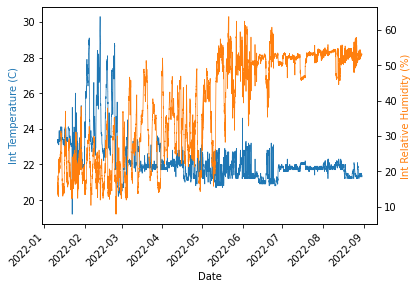

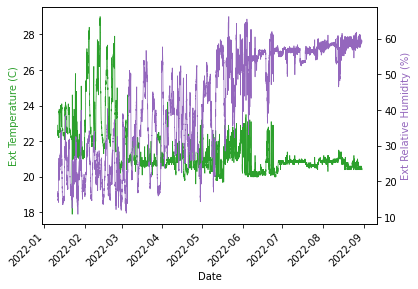

In [4]:

# USE FILENAME to add on to single dataframe rather than make higher dimensional df? 



# Add smoothing option? 



i = 1

#for i in range (0, len(file_names)):
df = (pd.read_csv(file_names[i], skiprows=7, sep='\s*,', engine = 'python', skipinitialspace=True, skipfooter=1, names=['rh1','temp1','rh2','temp2','time','date']))
#leading spaces after first row of data cause import issues. Skipping header + initial row of data appears to have fixed this issue. 
# final row is just four spaces/ indent --> deleted with skipfooter=1

#df.info()
# First RH imported with '+' - need to remove
df = df.replace({'\x00':'','\+':'','----':'0'},regex=True) # delete leading null and +

#df = df.replace({'\x00':'','\+':''},regex=True) # delete leading null and +


 # convert to float
df.rh1 = pd.to_numeric(df.rh1)
df.rh2 = pd.to_numeric(df.rh2) 
df.temp1 = pd.to_numeric(df.temp1)
df.temp2 = pd.to_numeric(df.temp2)

# Create new dataframe column with datetime format
df.loc[:,'datetime']= np.transpose([df.date + ' '+ df.time]) # combine date and time
df.datetime = pd.to_datetime(df.datetime) # convert to datetime format (NOTE: seems slow)

# delete 2012 data 
# hygrometer defaults to year 2012 before date is set, removing this data since it is not useful
datecut = datetime.datetime.strptime('01-01-2013 00:00:00','%m-%d-%Y %H:%M:%S')
df = df.drop(df[df.datetime < datecut].index) # drop where dates are in 2012

#k = df.datetime > datecut
#df = df[k]

plot_hygrom(df)




#%%
# visualize in Jupyter notebook
# Slider widgets to change x and y axis



# save data to json (?)
    #check if json file exists
        # check for new data
        # add new data and save
    #else
        # create json file and save

# Plot for each lab



# %%

# %%


In [ ]:
plot_hygrom(df[0])